# 7 - Inference - flow copy

# Setup

In [ ]:
#@title Install dependencies
%%capture
!pip install TTS
!pip install git+https://github.com/openai/whisper.git -q
!pip install stable-ts
#!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs
!pip install edlib
!pip install timething
# !pip install noisereduce

In [ ]:
%%capture
!pip install madmom --upgrade
!pip install git+https://github.com/CPJKU/madmom --upgrade

In [ ]:
%%capture
!pip install madmom --upgrade
!pip install git+https://github.com/CPJKU/madmom --upgrade

In [ ]:
#@title Imports

from pathlib import Path
from google.colab import drive
import subprocess
from IPython.display import Audio
from tqdm.notebook import tqdm
import librosa
import whisper
from stable_whisper import stabilize_timestamps, load_model
import pandas as pd
import itertools
import edlib
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import shutil
import soundfile as sf
import madmom
#from scipy.io import wavfile
#import noisereduce as nr

In [ ]:
#@title Auxiliar functions
def display_audio(path):
  """Display an audio using a Jupyter widget"""
  x, sr = librosa.load(path)
  display(Audio(x, rate=sr))

def normalize_text(text):
  """Normalizes the text for the token matching and the reading"""
  text = text.replace("%", " por ciento ")
  text = text.replace('"', '')
  text = text.replace("'", '')
  text = text.replace("`", '')
  text = text.replace("¿", '')
  text = text.replace("¡", '')

  return text

def read_text(text, 
              model_name="tts_models/es/css10/vits", 
              model_path=None,
              out_path="/content/example.wav"):
  """Read a text using a model by its name"""
  assert not (model_path is not None and model_name is not None)
  text = normalize_text(text)
  status = subprocess.run(["tts", "--text", text, 
                           "--model_name", model_name, 
                           "--out_path", str(out_path)])
  if status.returncode:
    raise RuntimeError(f"Process finish with error {status}")
  return Path(out_path)


def transcribe(model, path, suppress_silence: bool=True):
  """Transcribe an audio with whisper and returs the timestamps of its tokens"""
  audio = whisper.load_audio(path)
  results = model.transcribe(audio, 
                             task='transcribe', 
                             language='es', 
                             suppress_silence=suppress_silence)
  stab_segments = stabilize_timestamps(results, top_focus=True)

  return {'segments': stab_segments, 'text': results["text"]}

def extract_word_timestamps(segments, normalize=False, return_text=False):
  """Extracts a list with the tokens and its timestamps"""
  words = list(itertools.chain(*(pd.DataFrame(segments).whole_word_timestamps)))

  for i, word in enumerate(words):
    word["index"] = i
    if normalize:
      word["word"] = normalize_text(word["word"])

  if return_text:
    text = ''.join([word["word"] for word in words]).lower()
    return words, text

  return words

def expand_cigar_format(cigar:str):
  """Expand the cigar compact format returned by edlib"""
  path = []
  s = ""
  for c in cigar:
    if c.isdigit():
      s += c
    else:
      n = int(s)
      s = ""
      path.append({"reps": n, "operation": c})
  return path

def map_tokens(tokens):
  """Return a list to map the number of char in the text with the number of token"""
  token_map = []
  n_char = 0
  for n_token, token in enumerate(tokens):
    for c in token['word']:
      token_map.append(n_token)
      n_char += 1
  return token_map

def match_tokens(segments_target, segment_query):
  """Matches the tokens between the two segments"""
  tarqet_timestamps, target_text = extract_word_timestamps(segments_target, 
                                                  normalize=True, 
                                                  return_text=True)
  query_timestamps, query_text = extract_word_timestamps(segment_query, 
                                            normalize=True, 
                                            return_text=True)


  char_aligment = edlib.align(query_text, target_text, task = "path")
  aligment_path = expand_cigar_format(char_aligment["cigar"])

  target_token_map = map_tokens(tarqet_timestamps)
  query_token_map = map_tokens(query_timestamps)

  matches = []
  t = q = 0
  for exp in aligment_path:
    reps = exp["reps"]
    op = exp["operation"]

    for n in range(reps):
      if op == "=" or op  == 'X':
        t += 1
        q += 1
      elif op == 'D':
        t += 1
      elif op == 'I':
        q += 1
      matches.append({
                      "token_t": target_token_map[t-1],
                      "token_q": query_token_map[q-1],
                      #"char_t": t-1, "char_q": q-1, # Also matches chars
                      })
      
  # Remove duplicates
  matches = pd.DataFrame(matches).drop_duplicates().to_dict(orient="records")

  return matches, tarqet_timestamps, query_timestamps

def group_matches(matches, invert=True):
  """Groups the repeated matches"""
  t = "token_t"
  q = "token_q"
  if invert:
    t, q = q, t

  matches_grouped = []
  
  current_match = {t: 0, q: []}
  for match in matches:
    if match[t] == current_match[t]:
      current_match[q].append(match[q])
    else:
      matches_grouped.append(current_match)
      current_match = {t: match[t], q: [match[q]]}



  return matches_grouped

def get_token_timestamp(tokens, timestamps):
  """Compute the token timestamp from the token matching list"""
  if isinstance(tokens, int):
    return timestamps[tokens]["timestamp"]
  else:
    return [timestamps[token]["timestamp"] for token in tokens]

def get_timestamps(matches, tarqet_timestamps, query_timestamps):


  timestamps = []
  for m in matches:
    
    timestamps.append({
        "target": get_token_timestamp(m["token_t"], tarqet_timestamps),
        "query":  get_token_timestamp(m["token_q"], query_timestamps)
        })

  return timestamps


def cut_query_timestamps(matches_timestamps, threshold:float=0.4):

  blocks = []
  block = [{'target': 0, "query": 0}]
  ts = 0
  for m in matches_timestamps:
    query = m['query']
    target = m['target']
    target_min = min(target)
    
    if ts + threshold < query:
      # New block
      blocks.append(block)
      block = [m]
    else:
      block.append(m)
    ts = query
  block.append(m)
    

  return blocks

def compute_block_limits(blocks, threshold=0.25):

  last = len(blocks) - 1
  block_with_lims = []
  for n, block in enumerate(blocks):
    if n == 0:
      previous_q_ts = 0
      previous_t_ts = 0
    else:
      previous_q_ts = np.max(blocks[n-1][-1]['query'])
      previous_t_ts = np.max(blocks[n-1][-1]['target'])

    if n == last:
      next_q_ts = 100000000
      next_t_ts = 100000000
    else:
      next_q_ts = np.min(blocks[n+1][0]['query'])
      next_t_ts = np.max(blocks[n+1][0]['target'])
    
    start_q = np.min(block[0]['query'])
    
    if start_q - previous_q_ts > threshold:
      start_q -= threshold
    else:
      start_q = (start_q + previous_q_ts) / 2

    start_t = np.min(block[0]['target'])

    if start_t - previous_t_ts > threshold:
      start_t -= threshold
    else:
      start_t = (previous_t_ts + start_t)/ 2

    end_q = np.max(block[0]['query'])
    if next_q_ts - end_q > threshold:
      end_q += threshold
    else:
      end_q = (end_q + next_q_ts) / 2

    end_t = np.max(block[0]['target'])
    if next_t_ts - end_q > threshold:
      end_t += threshold
    else:
      end_t = (end_t + next_t_ts) / 2
    
    end = 0
    block_with_lims.append(
        {
         "query_start": start_q, 
         "query_end": end_q,
         "target_start": start_t,
         "target_end": end_t,
         "block": block, 
         })
    
  return block_with_lims

def save_for_interence(input, output=None):
  input = Path(input)
  if output is None:
    name_parts = input.name.split('.')
    name_parts[0] = f"{name_parts[0]}_inference"
    name = '.'.join(name_parts)
    output = input.parent / name
  else:
    output = Path(output)
  #load model
  model = torch.load(input)
  keys = [k for k in model["model"].keys() if k.startswith('disc.')]
  for k in keys:
    del model["model"][k]

  torch.save(model, output)

  return output

def read_text(text, 
              model_name=None, 
              out_path="/content/example.wav"):
  """Read a text using a model by its name"""
  text = normalize_text(text)
  status = subprocess.run(["tts", "--text", text, 
                           "--model_name", model_name, 
                           "--out_path", str(out_path)])
  if status.returncode:
    raise RuntimeError(f"Process finish with error {status}")
  return Path(out_path)

def local_read_text(text, 
              model_path,
              config_path="/root/.local/share/tts/tts_models--es--css10--vits/config.json",
              out_path="/content/example.wav"):
  """Read a text using a model"""
  out_path = Path(out_path)
  status = subprocess.run(["tts", 
                           "--text", text, 
                           "--model_path", str(model_path),
                           "--config_path", str(config_path), 
                           "--out_path", str(out_path)])
  
  
  return out_path


def clean_noise(in_path, out_path=None):
  in_path = Path(in_path)
  if out_path is None:
    out_path = in_path
  else:
    out_path = Path(out_path)

  # load data
  rate, data = wavfile.read(in_path)
  # perform noise reduction
  reduced_noise = nr.reduce_noise(y=data, sr=rate)
  wavfile.write(out_path, rate, reduced_noise)

  return out_path

def adjust_block_start(x, sr, start, end, threshold):
  a, b = int(start * sr), int(end * sr)

  delay = np.argmin(x[a:b] < threshold)
  start += delay / sr

  return start 


def compute_silence_windows(x, sr, 
                            window=0.4, step=0.005, threshold=0.02, 
                            add_extended_limits=True):
  
  duration = x.shape[0] / sr
  n_steps = int(np.ceil(duration / step))
  x_abs = np.abs(x)
  step_frames = step*sr
  window_frames = int(window*sr)
  # Initialize values
  blocks = []
  current_silence = np.all(x_abs[:window_frames] < threshold)
  start = 0


  for n in range(n_steps):
    frame = int(n*step_frames)
    is_silence = np.all(
        x_abs[frame : frame+window_frames] < threshold
        )
    
    if is_silence != current_silence:
      # Toggle state
      current_silence = is_silence
      ts = n*step
      # Only include not silence blocks
      if is_silence: # Condition is inverse (previous block)
        adjusted_start = adjust_block_start(x, sr, start, ts, threshold)
        blocks.append({'start': adjusted_start, 'end': ts})
      start = ts

  # Last open
  if not is_silence:
    adjusted_start = adjust_block_start(x, sr, start, duration, threshold)
    blocks.append({'start': adjusted_start, 'end': duration})

  if add_extended_limits:
    last = len(blocks) - 1
    for i, b in enumerate(blocks):
      if i == 0:
        b['start_extended'] = 0
      else:
        b['start_extended'] = (b['start'] + blocks[i-1]['end']) / 2

      if i==last:
        b['end_extended'] = duration
      else:
        b['end_extended'] = (b['end'] + blocks[i+1]['start']) / 2

  return blocks

def merge_matches_and_blocks(blocks, matches_timestamps):
  ts = 0
  n = 0
  total_matches = len(matches_timestamps)
  for b in blocks:
    b['matches'] = []
    while n < total_matches:
      m = matches_timestamps[n]
      if m['query'] > b["end_extended"]:
        break
      b['matches'].append(m)
      
      n += 1

  
  return blocks 

def compute_l2_shift(blocks_matches):
  for b in blocks_matches:
    n = len(b['matches'])
    if n > 0:
      shift = 0
      for m in b['matches']:
        shift += m['target'] - m['query']
      b['shift'] = shift / n
    else:
      b['shift'] = None # No matches in this block

  return blocks

def merge_block_and_channels(block, channels, x, sr):

  start, end = block['start_extended'], block['end_extended']
  shift = block['shift']
  if shift is None: # No shift, no merge
    return channels

  start_frame = int(start*sr)
  for c in channels:
    if c['end'] < start_frame: # Join
      a, b = int((start+shift)*sr), int(np.ceil((end+shift)*sr))
      d = int(start*sr)
      e = d+(b-a)
      
      l = len(c['c'][a:b])
      dif_length = len(x[d:e]) - l
      if dif_length == 0:
        c['c'][a:b] = x[d:e]
      elif dif_length < 0:
        c['c'][a:b+dif_length] = x[d:e]
      else:
        c['c'][a:b+dif_length] = x[d:e-dif_length]
      c['end'] = d+l

      return channels

  # Overlaps with all existing channels
  new_channel = np.zeros_like(x)
  
  a, b = int((start+shift)*sr), int(np.ceil((end+shift)*sr))
  d = int(start*sr)
  e = d+(b-a)
  l = len(new_channel[a:b])
  dif_length = len(x[d:e]) - l
  if dif_length == 0:
    new_channel[a:b] = x[d:e]
  elif dif_length < 0:
    new_channel[a:b+dif_length] = x[d:e]
  else:
    new_channel[a:b] = x[d:e-dif_length-1]

  channels.append({'c': new_channel, 'end': d+l})

  return channels


  
def block_transformation_channels(wav, block_matches):
  x, sr = librosa.load(read_wav)
  channels = []
  for block in block_matches:
     channels = merge_block_and_channels(block, channels, x, sr)

  channels = [c['c'] for c in channels]

  return np.vstack(channels), sr

def save_wav_per_channel(channels, sr, folder):
  folder = Path(folder)
  outputs = []
  for i, c in enumerate(channels):
    filename = folder / f'channel_{i}.wav'
    sf.write(filename, c, sr)
    outputs.append(filename)
  return outputs

def compute_l1_shift(blocks_matches):
  for b in blocks_matches:
    n = len(b['matches'])
    if n > 0:

      diffs = [m['target'] - m['query'] for m in b['matches']]
      b['shift'] = np.median(diffs)
     
    else:
      b['shift'] = None # No matches in this block

  return blocks

def remove_overlapping(blocks_matches):
  for i, b in enumerate(blocks_matches):
    if i==0: continue

    previous = blocks_matches[i-i]

    new_start = b['start'] + b['shift']
    previous_end = previous['end'] + previous['shift']
    diff = new_start - previous_end
    b['shift'] += min(diff, 0)
    

  return blocks

def compute_first_shift(blocks_matches):
  for b in blocks_matches:
    n = len(b['matches'])
    if n > 0:
      m = diffs = b['matches'][0]
      
      b['shift'] = m['target'] - m['query']
     
    else:
      b['shift'] = None # No matches in this block

  return blocks


def detect_beat_times(filename):
  proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
  act = madmom.features.beats.RNNBeatProcessor()(str(filename))
  beat_times = proc(act)
  return beat_times


def display_block(x, sr, blocks, n, extended=True):
  
  extra = "_extended" if extended else ''
  start = blocks[n][f'start{extra}']
  end = blocks[n][f'end{extra}']
  display(Audio(x[int(start*sr):int(end*sr)], rate=sr))



In [ ]:
#@title Mount drive

drive.mount("/content/drive/")

Mounted at /content/drive/


### Load whisper model

In [ ]:
whisper_model = load_model("large")

100%|█████████████████████████████████████| 2.87G/2.87G [00:50<00:00, 61.5MiB/s]


### Load tts models (default and own)

In [ ]:
text_example = ("Cuanto peor mejor para todos"
"y cuanto peor para todos mejor. Mejor para mí, el suyo, beneficio político."
"Es el vecino el que elige al alcalde y es el alcalde el que quiere que sean los vecinos el alcalde. Fin de la cita")

example_wav = read_text(text_example, model_name="tts_models/es/css10/vits")
display_audio(example_wav)

In [ ]:
drive_root = Path("/content/drive/MyDrive/Máster/DLASP/Final/")
content_path = Path("/content/")
rap_model_path = drive_root / "best_model_476866.pth"
rap_model_path = shutil.copy(rap_model_path, content_path / rap_model_path.name)
rap_model_path = save_for_interence(rap_model_path)

In [ ]:
text_example = ("Cuanto peor mejor para todos."
"y cuanto peor para todos mejor. Mejor para mí, el suyo, beneficio político."
"Es el vecino el que elige al alcalde y es el alcalde el que quiere que sean los vecinos el alcalde. Fin de la cita")
example_wav = local_read_text(text_example, rap_model_path)
display_audio(example_wav)

In [19]:
text_example = """
Puta mierda manchada,
pero hay que ser el mejor del periodista.
que al final está en la calle,
y que el respeto está en la piel.
que grita si te acuestas si me tienes que acabar.
que desde que te quedas en tu primera vez,
que mañana que me tenga que hacer.
estoy en el parque y me hace estar en casa,
pero nunca se me va a decir que lo puedo creer.
Los problemas en las nubes, con el corazón mal.
"""
"""
abrazarte y no escucharme nada más.
Sé que venga es más difícil que el humo sin dueño
a veces me la suda el mundo a ti todo lo que quiero
si no le dan un paso a los niños que se hacen malos
cuestión de sueños en la sombra de la calle,
pero mientras estás a mi lado a mi mente se creen
yo soy una mierda como el maldito perfume,
así que cállate ya el talento de los peces
desde el coño habláis de mí
que lo hago por el suelo
que este represento no se termina
mi corazón es mi crónica, mi red, es como el portero
a mí me da igual lo que digan, no es cierto
mi rollo es ser un chico que cabe en la calle
siento el alma sin prisa
por eso se fue y solo es pasajero
me llaman trabajo y me dejé a partir el cielo
y si me pierdo voy a contarte mis cabrones
y me pide a mentiras que me dejen mejor que me he conocido
y me hago más de lo que pienso
lo que me hace destrozar como una boca de mierda
pero no quiero que me toquen en lo más alto
estoy escribiendo los pretéritos
mi cabeza es un pedazo
entre la intención de estar en mis cascos
tengo mi mente a mí mismo
yo me acostumbré a vernos de su cuerpo
de dos mil ganas de tirar de mi casa
mira mi vida es de colores
y sin dudar mi parte de nadie pueda decir que la esperanza
y el alma se apaga y no se puede evitar
mis manos lo mantengan a la calle
me gusta el pero lo que no me han visto"""
example_text = text_example.replace('\n', ' ')

In [20]:
text_example = ("Cuanto peor mejor para todos."
"y cuanto peor para todos mejor. Mejor para mí, el suyo, beneficio político."
"Es el vecino el que elige al alcalde y es el alcalde el que quiere que sean los vecinos el alcalde. Fin de la cita")
example_wav = local_read_text(example_text, rap_model_path)
display_audio(example_wav)

Define song with paths previously separated (see notebook 1)

In [ ]:
drive_root = Path("/content/drive/MyDrive/Máster/DLASP/Final/")
song_path = drive_root / "songs_separated/htdemucs/52_esclavos_del_destino"
vocals =  song_path / "vocals.mp3"
vocals_wav =  song_path / "vocals.wav"
drums =  song_path / "drums.mp3"
bass =  song_path / "bass.mp3"
other =  song_path / "other.mp3"


read_text_path = "/content/read_text.wav"

### Transcribe original vocals

Original vocals

In [ ]:
display_audio(vocals)

Output hidden; open in https://colab.research.google.com to view.

Transcribe original vocals

In [ ]:
res_original = transcribe(whisper_model, vocals)

In [ ]:
# I dont have a normalizers digits -> spanish text. Computed manually
original_text = res_original["text"].replace("90", "noventa")

original_text

' La codicia ha contaminado las almas de los hombres. Ha levantado en el mundo barricadas de envidia, de rencor. Nos ha llevado a la miseria y a la matanza. Hemos crecido demasiado deprisa. ¿Y de qué ha servido? La tecnología, que proporciona abundancia, nos ha dejado en la indigencia. La inteligencia nos ha hecho cínicos. Nuestra inteligencia, duros y vacíos. Hemos empezado a pensar, pero hemos dejado de sentir. Nos hemos convertido en esclavos del destino. ¿Lo has pensado? ¿Realidad o imaginación? Han dado órdenes al jefe del estado de cada nación. Conspiración contra nuestra libertad, lo llamo. Respiramos ansiedad y no avanzamos. Las empresas, modernas cámaras de gas, autómatas sin nombre, redactan otro informe más sobre el progreso. ¿Qué progreso? Yo solo veo chavales de primero de eso, adictos al exceso. Nos aprietan las tuercas, la masa tuerta. No puede vivir sin el tono de un móvil cerca. La educación es cerca y nos amuerma. Enferma porque el director contrata siempre al profeso

Read with own tts

In [ ]:
read_wav = local_read_text(text=original_text.strip(), 
                           model_path=rap_model_path, 
                           out_path=read_text_path)

In [ ]:
display_audio(read_wav)

Output hidden; open in https://colab.research.google.com to view.

Transcribe output of tts system

In [ ]:
res_read = transcribe(whisper_model, read_wav)
res_read["text"]

" La codicia ha contaminado las almas de los hombres. Ha levantado en el mundo barricadas de envidia, de rencor. Nos ha llevado a la miseria y a la matanza. Hemos crecido demasiado deprisa. ¿Y de qué ha servido? La tecnología que proporciona abundancia nos ha dejado en la indigencia. La inteligencia nos ha hecho cínicos. Nuestra inteligencia, duros y vacíos. Hemos empezado a pensar, pero hemos dejado de sentir. Nos hemos convertido en esclavos del destino. ¿Lo has pensado? ¿Realidad o imaginación? Han dado órdenes al jefe del estado de cada nación. Conspiración contra nuestra libertad. Lo llamo. Respiramos ansiedad y no avanzamos. Las empresas modernas, cámaras de gas, autómatas sin nombre, redactan otro informe más sobre el progreso. ¿Qué progreso? Yo solo veo chavales deprimero de eso, adictos al exceso. Nos aprietan las tuercas, la masa tuerta. No puede vivir sin el tono de un móvil cerca. La educación es cerca y no se muerma. Enferma porque el director contrata siempre al profesor 

In [ ]:
#@title Aligment -> Criterion l2 aligment using whisper token timestamps
matches, tarqet_timestamps, query_timestamps = match_tokens(res_original["segments"], res_read["segments"])
matches_timestamps = get_timestamps(matches, tarqet_timestamps, query_timestamps)

x, sr = librosa.load(read_wav)
blocks = compute_silence_windows(x, sr, window=0.3, threshold=0.1)
blocks_matches = merge_matches_and_blocks(blocks, matches_timestamps)
blocks_matches = compute_l2_shift(blocks_matches)

channels, sr = block_transformation_channels(read_wav, blocks_matches)
l2_folder = drive_root / "copy_flow/l2/"
l2_folder.mkdir(exist_ok=True)
save_wav_per_channel(channels, sr, l2_folder)

[PosixPath('/content/drive/MyDrive/Máster/DLASP/Final/copy_flow/l2/channel_0.wav'),
 PosixPath('/content/drive/MyDrive/Máster/DLASP/Final/copy_flow/l2/channel_1.wav')]

## Beat identification

In [ ]:
example_song = drive_root / "songs/3_palabras.mp3"

In [ ]:
x, sr = librosa.load(example_song)
tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=91, units='time')
clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
Audio(x + clicks, rate=sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# approach 2 - dbn tracker
proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()(str(example_song))

beat_times = proc(act)

clicks = librosa.clicks(beat_times, sr=sr, length=len(x))

#sf.write("/content/beat_traking.wav", x+clicks, sr)

Audio(x + clicks, rate=sr)

Output hidden; open in https://colab.research.google.com to view.

## Join beat and music

In [ ]:
detect_song = drive_root / "songs/52_esclavos_del_destino.mp3"


In [ ]:
x, sr = librosa.load(detect_song)
beats = detect_beat_times(detect_song)

detect first beat with audio

In [ ]:
vocals_x, sr = librosa.load(vocals)
first = np.argmax(vocals_x > 0.2) / sr
first = np.argmin(np.abs(beats - first)) - 1

Anotate beats, bars and rounds to check if it works

In [ ]:
# Detect first 
clicks = librosa.clicks(beats[first:], sr=sr, length=len(x))
bars = librosa.clicks(beats[first::4], sr=sr, length=len(x), click_freq=2000)
rounds = librosa.clicks(beats[first+4::16], sr=sr, length=len(x), click_freq=4000)
sf.write("/content/beat_traking_esclavos.wav", x+clicks+bars+rounds, sr)

Compute the blocks using the text readed by the tts system

In [ ]:
read_x, sr = librosa.load(read_wav)
blocks = compute_silence_windows(read_x, sr, window=0.6, threshold=0.3)
len(blocks)

85

Check if it is correct -> One block

In [ ]:


n=18

display_block(read_x, sr, blocks, n)
blocks[n]

{'start': 49.97773242630386,
 'end': 55.11,
 'start_extended': 49.57386621315193,
 'end_extended': 55.460980725623585}

In [ ]:
num_beats = len(beats)
beat_n = 15
#for b in blocks:
#  print(b)

{'start': 0.0927437641723356, 'end': 2.99, 'start_extended': 0, 'end_extended': 3.883979591836735}
{'start': 4.777959183673469, 'end': 7.95, 'start_extended': 3.883979591836735, 'end_extended': 8.456842403628118}
{'start': 8.963684807256236, 'end': 11.205, 'start_extended': 8.456842403628118, 'end_extended': 11.924472789115647}
{'start': 12.643945578231293, 'end': 14.485, 'start_extended': 11.924472789115647, 'end_extended': 15.233384353741496}
{'start': 15.981768707482994, 'end': 16.775, 'start_extended': 15.233384353741496, 'end_extended': 17.37530045351474}
{'start': 17.975600907029477, 'end': 24.02, 'start_extended': 17.37530045351474, 'end_extended': 24.55180839002268}
{'start': 25.083616780045354, 'end': 27.205000000000002, 'start_extended': 24.55180839002268, 'end_extended': 27.70310657596372}
{'start': 28.201213151927437, 'end': 31.0, 'start_extended': 27.70310657596372, 'end_extended': 31.567035147392293}
{'start': 32.134070294784586, 'end': 34.410000000000004, 'start_extended

In [ ]:
n = 4
len(blocks)
#Audio(read_x[])
#display_audio

4

In [ ]:
s = blocks[0].copy()
s['shift'] = 41.54 - s['start']
channels, sr = block_transformation_channels(read_wav, [s])

In [ ]:
sf.write("/content/beat_traking_esclavos.wav", channels[0], sr)

# Aux plots

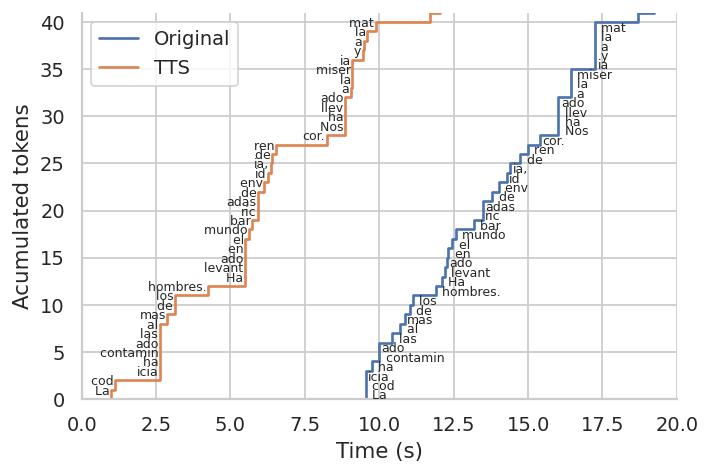

In [ ]:
fig, ax = plt.subplots(dpi=128)
sns.set_style("whitegrid")
ax.step([t['timestamp']  for t in tarqet_timestamps], 
         range(len(tarqet_timestamps)),
         label="Original")
ax.step([t['timestamp'] for t in query_timestamps], 
         range(len(query_timestamps)), 
         label="TTS")

ax.set_ylabel("Acumulated tokens")
ax.set_xlabel("Time (s)")

for i, w in enumerate(tarqet_timestamps[:40]):
  ax.text(x=w["timestamp"]+0.08, y=i-0, s=w["word"], fontsize=7, stretch=1000, ha="left")

for i, w in enumerate(query_timestamps[:40]):
  ax.text(x=w["timestamp"] - 0.05, y=i+0.5, s=w["word"], fontsize=7, stretch=1000, ha="right")


ax.set_xlim(0, 20)
ax.set_ylim(0, 41)
ax.legend()
sns.despine()

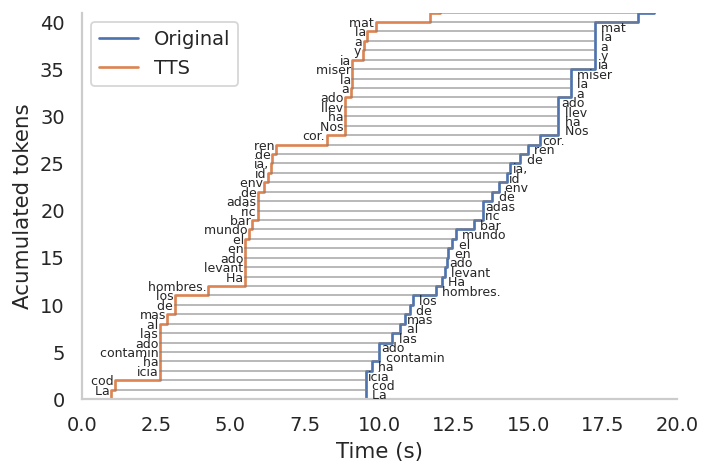

In [ ]:
fig, ax = plt.subplots(dpi=128)
sns.set_style("whitegrid")
ax.step([t['timestamp']  for t in tarqet_timestamps], 
         range(len(tarqet_timestamps)),
         label="Original")
ax.step([t['timestamp'] for t in query_timestamps], 
         range(len(query_timestamps)), 
         label="TTS")

ax.set_ylabel("Acumulated tokens")
ax.set_xlabel("Time (s)")

for i, w in enumerate(tarqet_timestamps[:40]):
  ax.text(x=w["timestamp"]+0.08, y=i-0, s=w["word"], fontsize=7, stretch=1000, ha="left")

for i, w in enumerate(query_timestamps[:40]):
  ax.text(x=w["timestamp"] - 0.05, y=i+0.5, s=w["word"], fontsize=7, stretch=1000, ha="right")

for m, mt in zip(matches, matches_timestamps):
  a, at = m["token_q"], mt["query"]
  for b, bt in zip(m["token_t"], mt["target"]):
    plt.plot([at, bt], [a, b], lw=1, alpha=0.6, color="gray")

ax.set_xlim(0, 20)
ax.set_ylim(0, 41)
ax.legend()
ax.grid(False)
sns.despine()

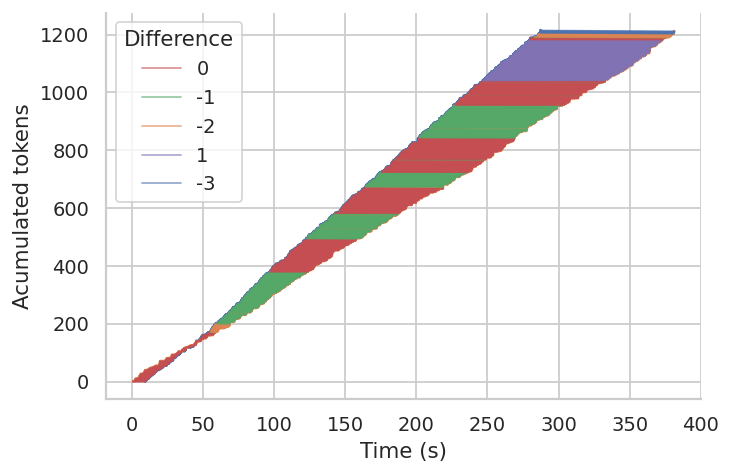

In [ ]:
fig, ax = plt.subplots(dpi=128)
sns.set_style("whitegrid")
ax.step([t['timestamp']  for t in tarqet_timestamps], 
         range(len(tarqet_timestamps)),
         )
ax.step([t['timestamp'] for t in query_timestamps], 
         range(len(query_timestamps)), 
         )

ax.set_ylabel("Acumulated tokens")
ax.set_xlabel("Time (s)")

#for i, w in enumerate(tarqet_timestamps):
#  ax.text(x=w["timestamp"]+0.08, y=i-0, s=w["word"], fontsize=7, stretch=1000, ha="left")

#for i, w in enumerate(query_timestamps[:40]):
#  ax.text(x=w["timestamp"] - 0.05, y=i+0.5, s=w["word"], fontsize=7, stretch=1000, ha="right")

for m, mt in zip(matches, matches_timestamps):
  a, at = m["token_q"], mt["query"]
  for b, bt in zip(m["token_t"], mt["target"]):
    plt.plot([at, bt], [a, b], lw=1, alpha=0.6, color=f"C{abs(3+a-b)}", label=f"{a-b}")

#ax.set_xlim(250, 260)
#ax.set_ylim(800, 1100)
ax.legend()
sns.despine()

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Difference");

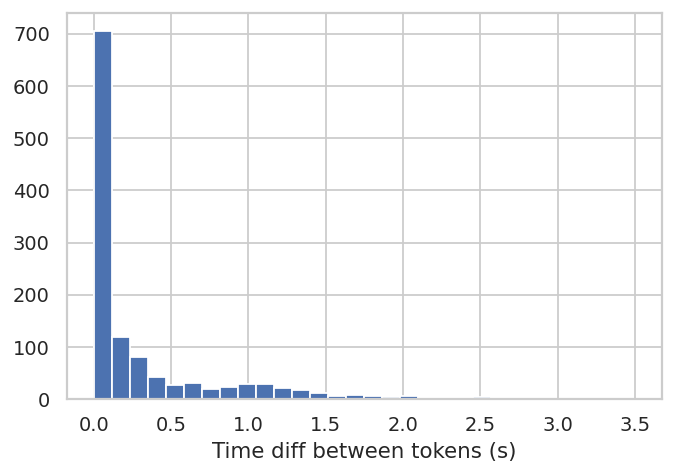

In [ ]:
fig, ax = plt.subplots(dpi=128)
ax.hist(np.diff([m['query'] for m in matches_timestamps]), bins=30)
ax.set_xlabel("Time diff between tokens (s)")
ax.set_label("Count")

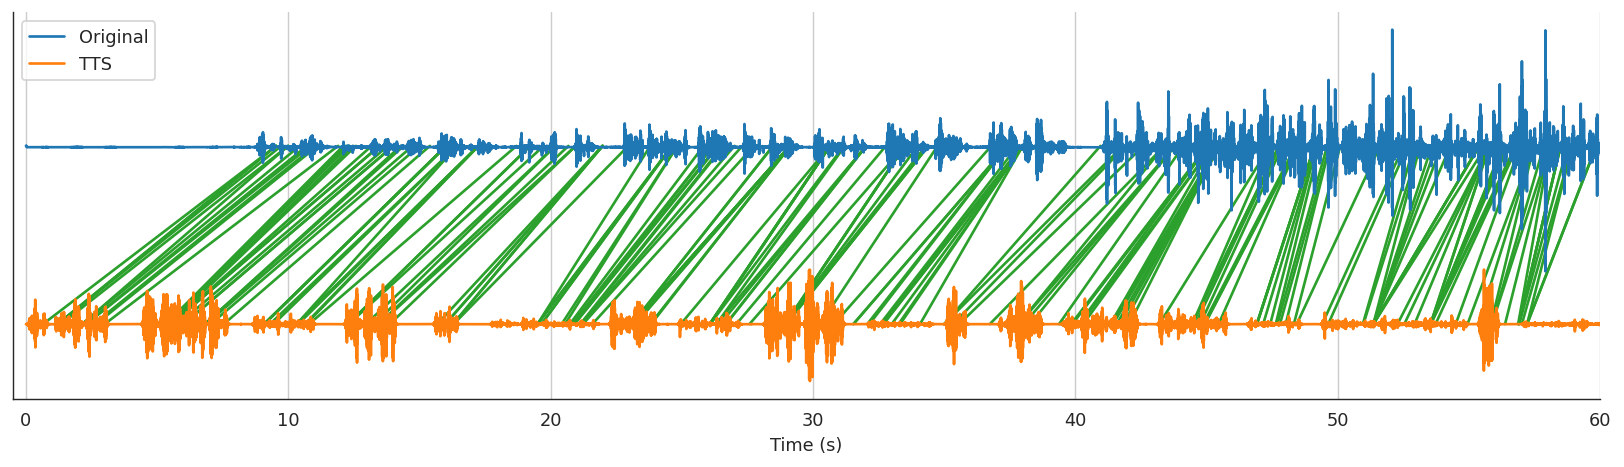

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 4), dpi=128)

rate_low = 256
x1, sr1 = librosa.load(vocals)
x1_subsampled = librosa.resample(x1, sr1, rate_low)

x2, sr2 = librosa.load(read_wav)
x2_subsampled = librosa.resample(x2, sr2, rate_low)

segs_1, segs_2 = 60, 60
base = -0.12

ax.plot(np.linspace(0, segs_1,segs_1*rate_low), 
                    x1_subsampled[:rate_low*segs_1],
        label="Original", zorder=15)
ax.plot(np.linspace(0, segs_2,segs_2*rate_low), 
        (x2_subsampled[:rate_low*segs_2]) + base,
        label="TTS", zorder=15)

ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine(ax=ax)
ax.grid()
ax.set_xlim(-0.5, 60)
for m in matches_timestamps:
  if m["target"] > 60 or m["query"] > 60:
    break

  ax.plot([m["query"], m["target"]], [base, 0], color="C2", zorder=5)
  



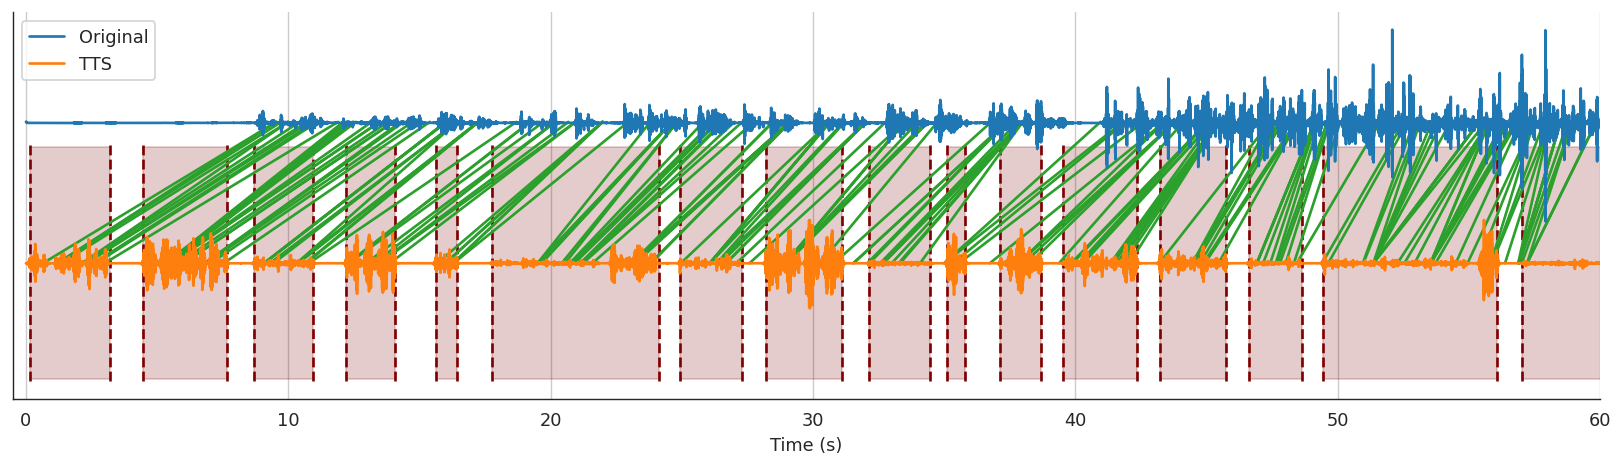

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 4), dpi=128)

rate_low = 256
x1, sr1 = librosa.load(vocals)
x1_subsampled = librosa.resample(x1, sr1, rate_low)

x2, sr2 = librosa.load(read_wav)
x2_subsampled = librosa.resample(x2, sr2, rate_low)

segs_1, segs_2 = 60, 60
base = -0.12

ax.plot(np.linspace(0, segs_1,segs_1*rate_low), 
                    x1_subsampled[:rate_low*segs_1],
        label="Original", zorder=15)
ax.plot(np.linspace(0, segs_2,segs_2*rate_low), 
        (x2_subsampled[:rate_low*segs_2]) + base,
        label="TTS", zorder=15)

ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine(ax=ax)
ax.grid()
ax.set_xlim(-0.5, 60)
for m in matches_timestamps:
  if m["target"] > 60 or m["query"] > 60:
    break

  ax.plot([m["query"], m["target"]], [base, 0], color="C2", zorder=5)
  
for b in blocks:
  start = b['start']
  end = b['end']
  if start > segs_2: break
  
  ax.axvspan(start, end, alpha=0.2, color='maroon', ymax=0.65, ymin=0.05)
  
  ax.plot([start, start], [base-0.1, base+0.1], ls='--', color='maroon')
  ax.plot([end, end], [base-0.1, base+0.1], ls='--', color='maroon')


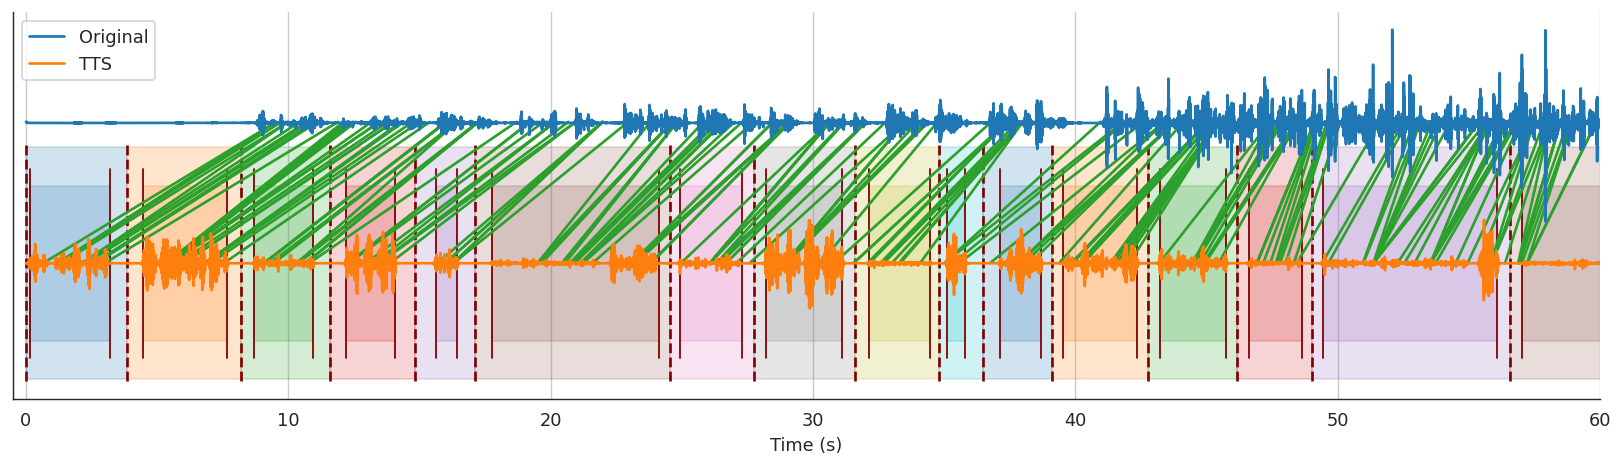

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 4), dpi=128)

rate_low = 256
x1, sr1 = librosa.load(vocals)
x1_subsampled = librosa.resample(x1, sr1, rate_low)

x2, sr2 = librosa.load(read_wav)
x2_subsampled = librosa.resample(x2, sr2, rate_low)

segs_1, segs_2 = 60, 60
base = -0.12

ax.plot(np.linspace(0, segs_1,segs_1*rate_low), 
                    x1_subsampled[:rate_low*segs_1],
        label="Original", zorder=15)
ax.plot(np.linspace(0, segs_2,segs_2*rate_low), 
        (x2_subsampled[:rate_low*segs_2]) + base,
        label="TTS", zorder=15)

ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine(ax=ax)
ax.grid()
ax.set_xlim(-0.5, 60)
for m in matches_timestamps:
  if m["target"] > 60 or m["query"] > 60:
    break

  ax.plot([m["query"], m["target"]], [base, 0], color="C2", zorder=5)
  
for i, b in enumerate(blocks):
  start = b['start']
  end = b['end']
  if start > segs_2: break
  
  ax.axvspan(b['start_extended'], b['end_extended'], alpha=0.2, color=f"C{i}", ymax=0.65, ymin=0.05)
  ax.axvspan(start, end, alpha=0.2, color=f"C{i}", ymax=0.55, ymin=0.15)
  
  ax.plot([start, start], [base-0.08, base+0.08], ls='-', lw=1, color='maroon')
  ax.plot([b['start_extended'], b['start_extended']], [base-0.1, base+0.1], 
          ls='--', color='maroon')
  ax.plot([end, end], [base-0.08, base+0.08], ls='-', lw=1, color='maroon')


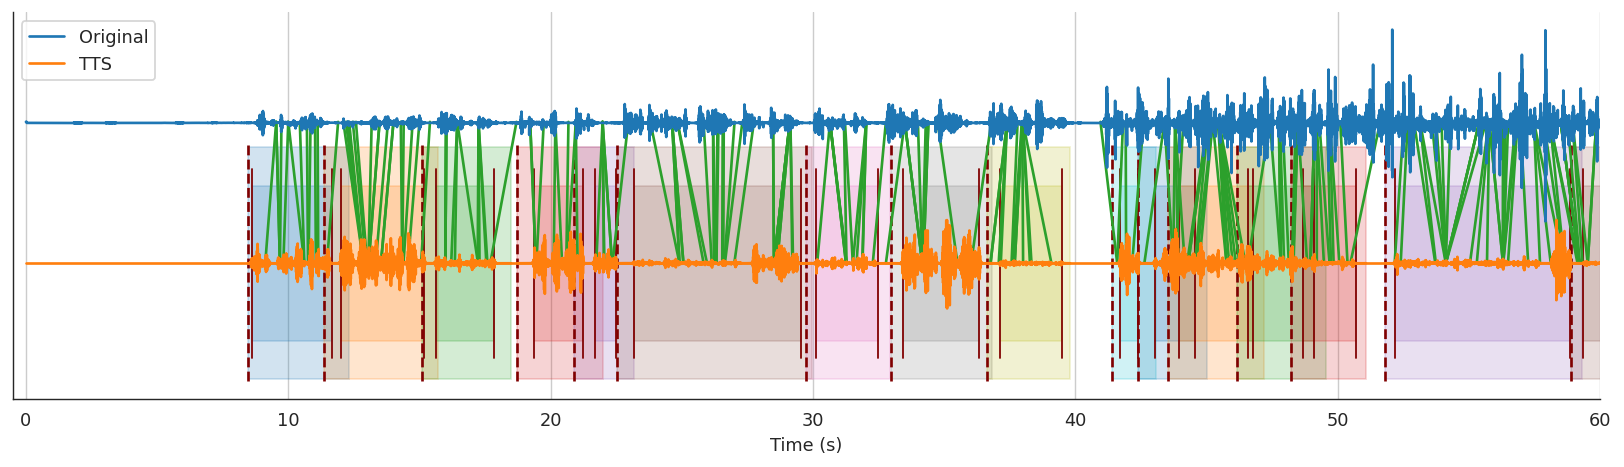

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 4), dpi=128)

rate_low = 256
x1, sr1 = librosa.load(vocals)
x1_subsampled = librosa.resample(x1, sr1, rate_low)

x2, sr2 = librosa.load(read_wav)
x2_subsampled = librosa.resample(x2, sr2, rate_low)

segs_1, segs_2 = 60, 60
base = -0.12

ax.plot(np.linspace(0, segs_1,segs_1*rate_low), 
                    x1_subsampled[:rate_low*segs_1],
        label="Original", zorder=15)
ax.plot([0, segs_2], [base, base],
         label="TTS", zorder=15)

ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine(ax=ax)
ax.grid()
ax.set_xlim(-0.5, 60)
# for m in matches_timestamps:
#   if m["target"] > 60 or m["query"] > 60:
#     break

#   ax.plot([m["query"], m["target"]], [base, 0], color="C2", zorder=5)
  
for i, b in enumerate(blocks):
  s = b['shift']
  start = b['start']
  end = b['end']
  if start > segs_2: break
  
  ax.axvspan(b['start_extended']+s, b['end_extended']+s, alpha=0.2, color=f"C{i}", ymax=0.65, ymin=0.05)
  ax.axvspan(start+s, end+s, alpha=0.2, color=f"C{i}", ymax=0.55, ymin=0.15)
  
  ax.plot([start+s, start+s], [base-0.08, base+0.08], ls='-', lw=1, color=f"maroon")
  ax.plot([b['start_extended']+s, b['start_extended']+s], [base-0.1, base+0.1], 
          ls='--', color='maroon')
  ax.plot([end+s, end+s], [base-0.08, base+0.08], ls='-', lw=1, color='maroon')

  sub_wave = x2_subsampled[ int(b['start_extended']*rate_low):int(b['end_extended']*rate_low)] + base
  l = np.linspace(b['start_extended'], b['end_extended'], len(sub_wave)) + s

  ax.plot(l, sub_wave, zorder=15, color=f"C{1}")

  for m in b['matches']:
    if m["target"] > 60 or m["query"] > 60:
      break

    ax.plot([m["query"]+s, m["target"]], [base, 0], color="C2", zorder=5)